In [1]:
!cp -r /content/drive/MyDrive/Colab\ Notebooks/ece1512/projectB/annotated_images.zip .
!unzip annotated_images.zip

Archive:  annotated_images.zip
   creating: annotated_images/
  inflating: annotated_images/.DS_Store  
  inflating: __MACOSX/annotated_images/._.DS_Store  
   creating: annotated_images/test/
   creating: annotated_images/train/
  inflating: annotated_images/test/.DS_Store  
  inflating: __MACOSX/annotated_images/test/._.DS_Store  
   creating: annotated_images/test/HP/
   creating: annotated_images/test/SSA/
  inflating: annotated_images/train/.DS_Store  
  inflating: __MACOSX/annotated_images/train/._.DS_Store  
   creating: annotated_images/train/HP/
   creating: annotated_images/train/SSA/
  inflating: annotated_images/test/HP/MHIST_dkl.png  
  inflating: annotated_images/test/HP/MHIST_dhw.png  
  inflating: annotated_images/test/HP/MHIST_did.png  
  inflating: annotated_images/test/HP/MHIST_auy.png  
  inflating: annotated_images/test/HP/MHIST_ayz.png  
  inflating: annotated_images/test/HP/MHIST_cvw.png  
  inflating: annotated_images/test/HP/MHIST_and.png  
  inflating: annotat

In [2]:
from sklearn.metrics import f1_score
# from torchvision.transforms.transforms import RandomHorizontalFlip
import torch
from torchvision import transforms as T
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import os
from torchvision import models as models

dataset_path = "annotated_images"
test_transform = T.Compose([
    T.ToTensor()
])

test_dataset = ImageFolder(os.path.join(dataset_path, "test"), transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)


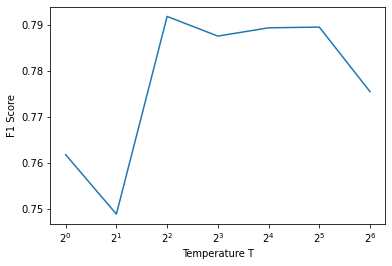

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def evaluate(model):
  model.to(device)
  model.eval()
  all_pred = []
  all_labels = []
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    pred = torch.argmax(model(inputs), axis=1)
    all_pred.append(pred)
    all_labels.append(labels)
  all_pred = torch.concat(all_pred).cpu().numpy()
  all_labels = torch.concat(all_labels).cpu().numpy()
  return f1_score(all_labels, all_pred)



y = []
for t in [1,2,4,8,16,32,64]:
  student_distill = torch.load("/content/drive/MyDrive/Colab Notebooks/ece1512/projectB/MHIST_student_distill_T_{}.pt".format(t), map_location="cpu")
  f1 = evaluate(student_distill)
  y.append(f1)

plt.plot([1,2,4,8,16,32,64], y)
plt.xlabel("Temperature T")
plt.xscale('log', basex=2)
plt.ylabel("F1 Score")
plt.savefig("Temperature vs F1 Score")



In [6]:
teacher = torch.load("/content/drive/MyDrive/Colab Notebooks/ece1512/projectB/MHIST_teacher_layers1234.pt", map_location='cpu')
student_nodistill = torch.load("/content/drive/MyDrive/Colab Notebooks/ece1512/projectB/MHIST_student_nodistill.pt", map_location='cpu')
fitnet = torch.load("/content/drive/MyDrive/Colab Notebooks/ece1512/projectB/MHIST_student_fitnet_stage2.pt", map_location='cpu')
print("The best distilled model has F1 score {}".format(max(y)))
print("The non-distill student model has F1 score {}".format(evaluate(student_nodistill)))
print("The teacher model has F1 score {}".format(evaluate(teacher)))
print("The fitnet model has F1 score {}".format(evaluate(fitnet)))

The best distilled model has F1 score 0.7917888563049854
The non-distill student model has F1 score 0.7720364741641338
The teacher model has F1 score 0.7836734693877552
The fitnet model has F1 score 0.8011611030478956


In [ ]:
print(y)

[0.7617554858934169, 0.74884437596302, 0.7917888563049854, 0.7875185735512631, 0.7893175074183977, 0.7894736842105262, 0.7754491017964072]


In [ ]:
# Calculate FLOPs and number of parameters
!pip install ptflops
from ptflops import get_model_complexity_info



macs, params = get_model_complexity_info(teacher, (3, 224, 224), as_strings=True,
                                           print_per_layer_stat=False, verbose=True)
print('{:<30}  {:<8}'.format('Teacher Model Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters in Teacher Model: ', params))

macs, params = get_model_complexity_info(student_nodistill, (3, 224, 224), as_strings=True,
                                           print_per_layer_stat=False, verbose=True)

print('{:<30}  {:<8}'.format('Student Model Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters in Student Model: ', params))




Teacher Model Computational complexity:   4.12 GMac
Number of parameters in Teacher Model:   22.07 M 
Student Model Computational complexity:   0.32 GMac
Number of parameters in Student Model:   2.23 M  
